In [1]:
import numpy as np
from Bio import SeqIO
import os

from sklearn.metrics import roc_curve, auc
from scipy import interp

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
test_motifxFamMatrix = np.genfromtxt('data_dev/new_test_motifxFamMatrix.csv',delimiter=',',dtype=int)
fams = np.genfromtxt('data_dev/fams.csv',dtype='U')

print(fams)

['PKA' 'AKT' 'CDK' 'MAPK' 'SRC' 'CK2' 'PKC' 'PIKK']


## Get MusiteDeep performance.

In [4]:
fams_musite = np.array(['CDK','CK2','MAPK','PKA','PKC'])
fam_idc_musite = [ np.where(fams==fam)[0][0] for fam in fams_musite ]
print(fam_idc_musite)

# Y-test for musite fams.
y_test_musite = test_motifxFamMatrix[:,fam_idc_musite]

# fasta_content = SeqIO.parse(open('data_dev/test_musite.fasta'),'fasta')
# test_seqs_mus = []
# for fasta in fasta_content:
#     name, sequence = fasta.id, str(fasta.seq)
#     test_seqs_mus.append(sequence)

# Go through produced files and fill out the y-score matrix.
y_score_musite = np.zeros((y_test_musite.shape[0],y_test_musite.shape[1]),dtype=float)

res_dir = "results_musite/"
for fam_file in os.listdir(res_dir):
    if "result" not in fam_file:
        continue
    fam = fam_file[7:-4]
#     print(fam)
    f_idx = np.where(fams_musite==fam)[0][0]
    ofile = open(os.path.join(res_dir, fam_file))
    lines = ofile.readlines()    
    for line in lines:
        line = [x.strip() for x in line.split('\t')]
        try:
            if line[1]=='26': # 25th amino acid ... the phosphosite
                m_idx = line[0].replace("\"","")
                m_idx = m_idx.replace(">","")
                m_idx = int(m_idx)
                y_score_musite[m_idx][f_idx] = float(line[3])     
        except Exception as e:
            print(m_idx,line,e)

[2, 5, 3, 0, 6]


## Get DeepPhos performance.

In [5]:
fams_deepphos = np.array(['CDK','CK2','MAPK','PKC'])
fam_idc_deepphos = [ np.where(fams==fam)[0][0] for fam in fams_deepphos ]
print(fam_idc_deepphos)

# Y-test for musite fams.
y_test_deepphos = test_motifxFamMatrix[:,fam_idc_deepphos]

# Go through produced files and fill out the y-score matrix.
y_score_deepphos = np.zeros((y_test_deepphos.shape[0],y_test_deepphos.shape[1]),dtype=float)

res_dir = "results_deepphos/"
res_subdirs = ["S","T"]

for sub in res_subdirs:
    this_dir = res_dir + sub + "//"
    
    for fam_file in os.listdir(this_dir):

        fam = fam_file [ fam_file.rfind('y_')+2 : fam_file.find('pred') ]
        print(sub,fam)
        
        f_idx = np.where(fams_deepphos==fam)[0][0]        
        ofile = open(os.path.join(this_dir, fam_file))
        lines = ofile.readlines()
        
        for line in lines:
            line = [x.strip() for x in line.split()]
            m_idx = line[0].replace("\"","")
            m_idx = int(m_idx)
            
            score = line[2].replace("\"","")
            y_score_deepphos[m_idx][f_idx] = float(score)

[2, 5, 3, 6]
S CDK
S CK2
S PKC
S MAPK
T CDK
T CK2
T PKC
T MAPK


In [6]:
which = 'musite'

if which=='deepphos':
    fams = fams_deepphos
    y_test = y_test_deepphos
    y_score = y_score_deepphos
elif which=='musite':
    fams = fams_musite
    y_test = y_test_musite
    y_score = y_score_musite

In [7]:
## ROC

FAM_IDC = [x for x in range(len(fams))]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

## PRECISION-RECALL

precision = dict()
recall = dict()
average_precision = dict()

for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
average_precision["macro"] = average_precision_score(y_test, y_score, average="macro")

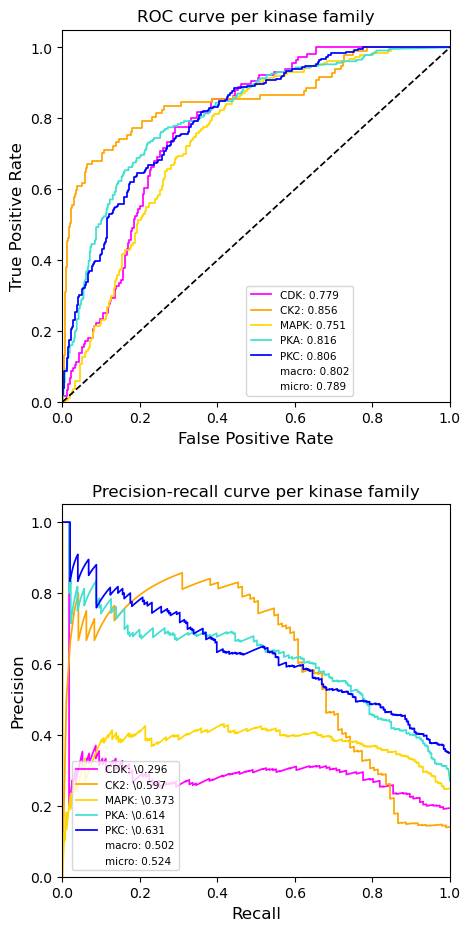

In [13]:
import matplotlib.pyplot as plt

fam_to_col = {'AKT': 'red',
 'CDK': 'magenta',
 'CK2': 'orange',
 'MAPK': 'gold',
 'PIKK': 'yellowgreen',
 'PKA': 'turquoise',
 'PKC': 'blue',
 'SRC': 'purple'}

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize=(5,11))
lw = 1.25

############################################################
###################  AUROC #################################
############################################################

lines = []
labels = []

l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('micro: {0:0.3f}'.format(roc_auc["micro"]))
l, = ax1.plot(0,0,color='white')
lines.append(l)
labels.append('macro: {0:0.3f}'.format(roc_auc["macro"]))

for i,fam in enumerate(fams):
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'    
    l, = ax1.plot(fpr[i], tpr[i], color=fam_to_col[fam], lw=lw,
             label='{0}: {1:0.3f}'.format(fclass, roc_auc[i]))
    labels.append('{0}: {1:0.3f}'.format(fclass, roc_auc[i]))
    lines.append(l)

fig.subplots_adjust(hspace=.275)
ax1.plot([0, 1], [0, 1], 'k--', lw=lw)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)
ax1.set_xlabel('False Positive Rate',fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12) 
ax1.set_title('ROC curve per kinase family',fontsize=12) 
labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax1.legend(lines, labels, loc=(0.475, .0175), fontsize=7.5)  # (1.05, .0)

############################################################
###############  PRECISION-RECALL ##########################
############################################################

lines = []
labels = []

l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('micro: {0:0.3f}'.format(average_precision["micro"]))
l, = ax2.plot(0,0,color='white')
lines.append(l)
labels.append('macro: {0:0.3f}'.format(average_precision["macro"]))

for i,fam in enumerate(fams):
    l, = ax2.plot(recall[i], precision[i], color=fam_to_col[fam], lw=lw)
    lines.append(l)
    fclass = fams[i]
    if fclass=='AKT':
        fclass = 'Akt'
    if fclass=='SRC':
        fclass = 'Src'
    labels.append('{0}: \{1:0.3f}'.format(fclass, average_precision[i]))

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)
ax2.set_xlabel('Recall',fontsize=12) 
ax2.set_ylabel('Precision',fontsize=12) 
ax2.set_title('Precision-recall curve per kinase family',fontsize=12) 

labels, lines = zip(*sorted(zip(labels, lines), key=lambda t: t[0], reverse=False))
ax2.legend(lines, labels, loc=(0.025, .0175), fontsize=7.5) # (1.05, .0)

plt.savefig("figs_comparisons/%s_roc-prc_FINAL_revised" % which, bbox_inches='tight')
plt.show()

In [16]:
test_motifxFamMatrix[0]

array([1, 0, 0, 0, 0, 1, 1, 0])

In [21]:
test_motifs = np.genfromtxt('data_dev/new_test_motifs.csv',dtype='U')
fams = np.genfromtxt('data_dev/fams.csv',dtype='U')

test_motifs[:5]

array(['APPEKAESEVAPGAP', 'RNLLEDDSDEEEDFF', 'SSAVRLRSSVPGVRL',
       'SYCEPPSYRPMHHED', 'SSVTVTRSYRSVGGS'], dtype='<U15')

In [22]:
for i,each in enumerate(test_motifs[:5]):
    print(each)
    for j,f in enumerate(test_motifxFamMatrix[i]):
        if f==1:
            print (fams[j])

APPEKAESEVAPGAP
PKA
CK2
PKC
RNLLEDDSDEEEDFF
CK2
SSAVRLRSSVPGVRL
PKA
SYCEPPSYRPMHHED
SRC
SSVTVTRSYRSVGGS
PKC


In [20]:
fams

array(['CDK', 'CK2', 'MAPK', 'PKC'], dtype='<U4')